In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class GPDM:
  def __init__(self, obs_dim, latend_dim, device="cuda" ):
    self.D = obs_dim
    self.Dz = latend_dim
    self.device = device

  def k(self, xi, xj, kparams):
    #return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 
    return kparams[0] * torch.exp(-0.5 * kparams[1] * torch.sum((xi - xj) * (xi - xj), 2)) 

  def cov(self, xi, xj, dim, kparams ):
    a = xi.view(-1,1,dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1,dim).repeat(len(xi), 1, 1)
    return self.k(a,b, kparams).float()

  def learn(self, x, num_itr):
    self.N = x.shape[0]
    self.D = x.shape[1]
    self.x = torch.tensor(x, dtype=torch.float32, device=self.device)
    self.params = torch.tensor( np.log([1, 1, 1, 1, 1, 1, 1, 1]), device=self.device, requires_grad=True )

    # PCAで初期化
    self.pca = PCA(n_components=self.Dz)
    self.z = torch.tensor( self.pca.fit_transform(x), dtype=torch.float32 ,requires_grad=True, device=self.device  )

    # ランダムな初期化
    #self.z = torch.tensor( np.random.rand(self.N, self.Dz), dtype=torch.float32 ,requires_grad=True  )


    optimizer = torch.optim.Adam( [self.params, self.z], lr=0.001)
    for i in range(num_itr):
      # 負の対数尤度（コスト関数）を定義
      # カーネルのパラメータ
      self.kparams_x = [ torch.exp(self.params[0]), torch.exp(self.params[1])]
      self.kparams_z = [ torch.exp(self.params[2]), torch.exp(self.params[3])]

      # xに関する変数
      self.alphax = torch.exp(self.params[4])
      self.betax =  torch.exp(self.params[5])+0.001
      self.Kx = self.alphax * self.cov(self.z, self.z, self.Dz, self.kparams_x) + self.betax * torch.eye(self.N, self.N, device=self.device)
      self.Kx_inv = torch.inverse( self.Kx )
      self.x_t = torch.t( self.x )

      # zに関する変数
      self.alphaz = torch.exp(self.params[6])
      self.betaz =  torch.exp(self.params[7])+0.001
      self.Kz = self.alphaz * self.cov(self.z[:-1], self.z[:-1], self.Dz, self.kparams_z) + self.betaz * torch.eye(self.N-1, self.N-1, device=self.device)
      self.Kz_inv = torch.inverse( self.Kz )
      self.zz = self.z[1:]
      self.zz_t = torch.t( self.zz )

      loss = 1/2 * torch.trace( torch.mm( torch.mm( self.Kx_inv, self.x ), self.x_t ) )
      loss += 1/2 * torch.trace( torch.mm( torch.mm( self.Kz_inv, self.zz ), self.zz_t ) )
      loss += self.Dz/2 * torch.logdet( self.Kz ) + self.D/2 * torch.logdet( self.Kx )

      # 最適化
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if i%10==0:
        print(loss, i)
        z = self.z.detach().cpu().numpy()
        plt.plot( z[:,0], z[:,1], "o-" )
        plt.show()

    return self.z.detach().cpu().numpy()

  def predict_next_z(self, pre_z ):
    pre_z = torch.tensor(pre_z, device=self.device).reshape(-1, self.Dz)

    kz = self.cov( pre_z, self.z[:-1], self.Dz, self.kparams_z )
    k = self.cov( pre_z, pre_z, self.Dz, self.kparams_z) + 1.0/self.betaz

    mu = torch.mm( torch.mm( kz, self.Kz_inv ), self.z[1:].reshape(-1,self.Dz) )
    sig = k - torch.mm( kz, torch.mm(self.Kz_inv, torch.t(kz)) )

    return mu.detach().cpu().numpy().flatten(), sig.diag().detach().cpu().numpy().flatten()*np.eye(self.Dz)

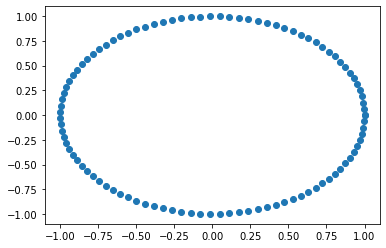

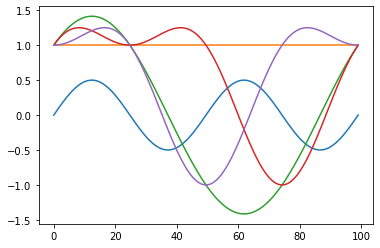

In [13]:
N = 100
D = 5

# 真の潜在変数を生成
t = np.linspace( 0, 2*np.pi, N )
z_true = np.zeros( (N, 2)  )

z_true[:,0] = np.cos(t)
z_true[:,1] = np.sin(t)

plt.plot( z_true[:,0], z_true[:,1], "o" )

# 潜在変数を適当に高次限化
x = np.zeros( (N, D) )
x[:,0] = [ z1*z2 for (z1,z2) in z_true ] 
x[:,1] = [ z1*z1+z2*z2 for (z1,z2) in z_true ] 
x[:,2] = [ z1 + z2 for (z1,z2) in z_true ] 
x[:,3] = [ z1*z1+z2 for (z1,z2) in z_true ] 
x[:,4] = [ z2*z2+z1 for (z1,z2) in z_true ] 

plt.figure()
for i in range(D):
  plt.plot( range(N), x[:,i])

tensor(79.6536, grad_fn=<AddBackward0>) 0


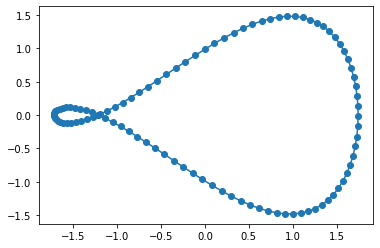

tensor(75.4728, grad_fn=<AddBackward0>) 10


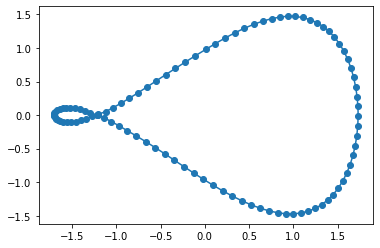

tensor(71.3268, grad_fn=<AddBackward0>) 20


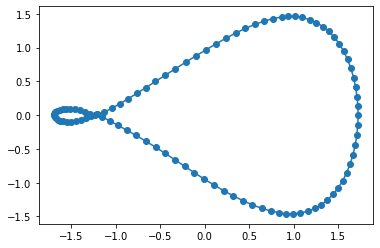

tensor(67.2159, grad_fn=<AddBackward0>) 30


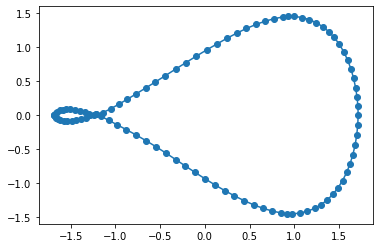

tensor(63.1389, grad_fn=<AddBackward0>) 40


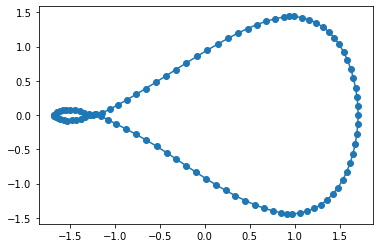

tensor(59.0926, grad_fn=<AddBackward0>) 50


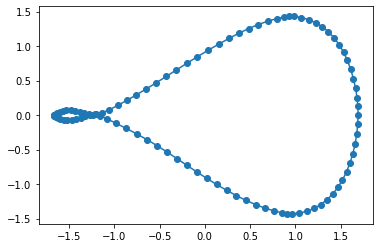

tensor(55.0737, grad_fn=<AddBackward0>) 60


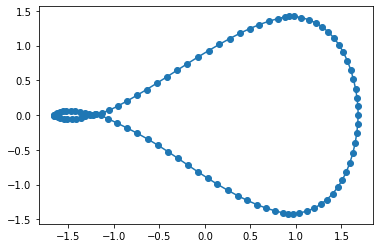

tensor(51.0796, grad_fn=<AddBackward0>) 70


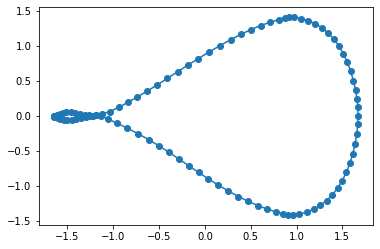

tensor(47.1086, grad_fn=<AddBackward0>) 80


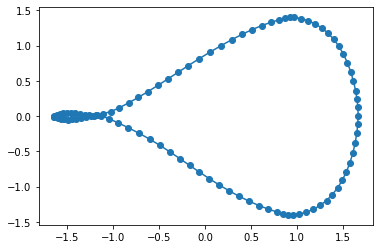

tensor(43.1587, grad_fn=<AddBackward0>) 90


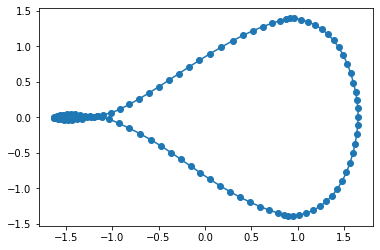

In [16]:
gp = GPDM(N, 2, "cpu")

# 学習
z = gp.learn(x, 100)

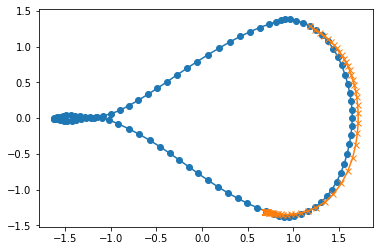

In [19]:
# 潜在変数を予測
z_sequence = []
z_pred = z[50]
z_sequence.append( z_pred )
for i in range(100):
  mu, sig = gp.predict_next_z( z_pred )
  z_pred = mu
  z_sequence.append( z_pred )

z_sequence = np.array( z_sequence )
plt.plot( z[:,0], z[:,1], "o-" )
plt.plot( z_sequence[:,0], z_sequence[:,1], "x-" )
plt.show()